In [1]:
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt

<h2>Importing Data</h2>

Data is obtained from the author of the following paper:

>Laura Alessandretti, Abeer ElBahrawy, Luca Maria Aiello, Andrea Baronchelli, "Anticipating Cryptocurrency Prices Using Machine Learning", Complexity, vol. 2018, Article ID 8983590, 16 pages, 2018. https://doi.org/10.1155/2018/8983590

In [2]:
data = pd.read_csv("./data/crypto-historical-data.csv")

In [3]:
data.head()

,Unnamed: 0,market cap,name,price,sym,time,volume
0,0,20461600.0,Viberate,0.114889,VIB,2018-04-01,4702470.0
1,1,19204400.0,Viberate,0.124845,VIB,2018-04-02,3688650.0
2,2,20825800.0,Viberate,0.133474,VIB,2018-04-03,3681530.0
3,3,22260000.0,Viberate,0.121755,VIB,2018-04-04,5583970.0
4,4,20086900.0,Viberate,0.118312,VIB,2018-04-05,2824800.0


<h2>Data Processing</h2>

The aim of this part is create the following variables:
1. Market Capitalization
2. Price
3. Rank: the rank of the cryptocurrency based on market capitalization
4. Market Share: ratio of market capitalization of the cryptocurrency and the total market capitalization over the entire cryptocurrency universe
5. Volume
6. Age: the number of days since the first time the cryptocurrency trades on the market
7. ROI: return on investment which is return of investment relative to cost of investment. Formula is shown below.

\begin{equation*}
ROI_{c, t} = \frac{P_{c, t} - P_{c, t-1}}{P_{c, t-1}}
\end{equation*}



In [5]:
def process(data):
#     cache_file = './data/processed_data.csv'
#     if os.path.isfile(cache_file):
#         processed_data = pd.read_csv(cache_file)
#     else:
    # Clean up data
    processed_data = data.copy()
    processed_data = processed_data.iloc[:, 1:]
    processed_data = processed_data.dropna()

    # Determine rank for each day
    processed_data = processed_data.rename(columns={"market cap": "market_cap"})
    processed_data['rank'] = processed_data.groupby("time")["market_cap"].rank("dense", ascending=False)

    # Calculate market share
    processed_data['market_share'] = processed_data.groupby('time')["market_cap"].apply(lambda x: x / float(x.sum()))

    # Calculate age
    processed_data = processed_data.sort_values(by=['sym', 'time'])
    processed_data['time'] = pd.to_datetime(processed_data['time'])
    processed_data['age'] = processed_data.groupby(['sym'])["time"].apply(lambda x: x - min(x))
    processed_data['age'] = processed_data['age'].fillna(pd.Timedelta(days=0))
    processed_data['age'] = processed_data['age'].dt.days

    # Calculate 1-day ROI
    processed_data['previous_price'] = processed_data.groupby(['sym'])['price'].shift(1)
    processed_data['roi'] = (processed_data['previous_price'] - processed_data['price'])/processed_data['price']
    processed_data['roi'] = processed_data['roi'].fillna(0)
    processed_data = processed_data.drop(columns='previous_price')
        
#         processed_data.to_csv(cache_file, index=False)
    
    return processed_data

In [6]:
processed_data = process(data)

In [7]:
processed_data.head()

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi
257046,2287.0,Money,0.000027,$$$,2015-12-11,1.0,281.0,3.331148e-07,0,0.000000
257049,1245.0,Money,0.000043,$$$,2015-12-12,0.0,294.0,1.672044e-07,1,-0.372093
257052,1996.0,Money,0.000022,$$$,2015-12-13,2.0,282.0,2.799685e-07,2,0.954545
257055,994.0,Money,0.000022,$$$,2015-12-14,3.0,291.0,1.387677e-07,3,0.000000
257058,1018.0,Money,0.000023,$$$,2015-12-15,2.0,296.0,1.396945e-07,4,-0.043478


<h2>Data Visualization</h2>

This part is meant to explore the data to identify possible trends, while at the same time make sure the processing was done correctly. Let's visualize the change in values over time for the top 10 coin by market capitalization as of April 24, 2018.

In [8]:
# Identify the top 10 coin based on market cap as of the latest date, April 24, 2018
latest_data = processed_data[processed_data['time'] == max(processed_data['time'])]
latest_top_10 = latest_data.nlargest(10, 'market_cap')['sym'].values

In [9]:
# Filter processed data to include only the top 10 symbols
all_data_top_10 = processed_data[processed_data['sym'].isin(latest_top_10)]

In [10]:
# Create separate dataframe for each symbol
df_container = {}

for sym in latest_top_10:
    sym_df = processed_data[processed_data['sym'] == sym]
    sym_df.index = sym_df['time']
    df_container[sym] = sym_df

In [11]:
def plotting(df_container, var):
    plt.figure(figsize=(10,5))

    for sym in df_container:
        df_container[sym][var].plot(label=sym, lw=1)

    plt.legend()
    plt.show()

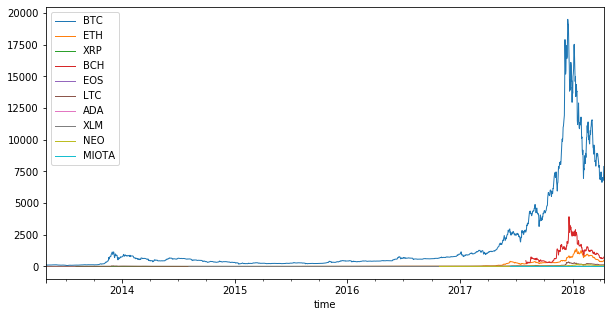

In [12]:
plotting(df_container, 'price')

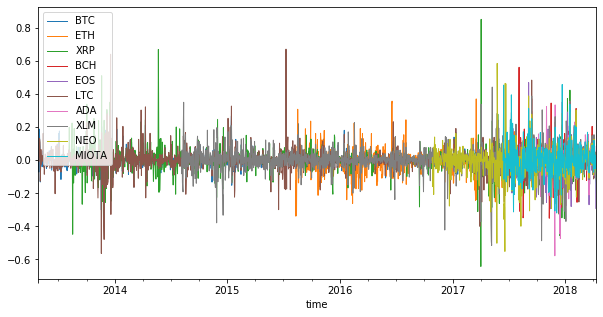

In [13]:
plotting(df_container, 'roi')

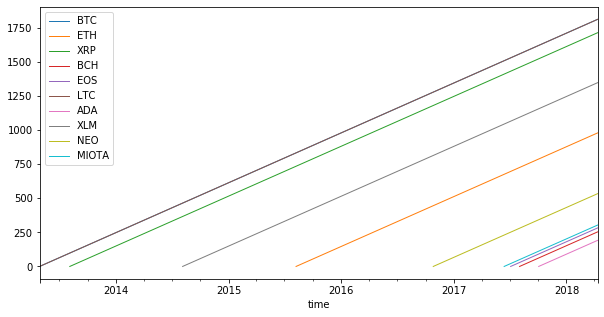

In [14]:
plotting(df_container, 'age')

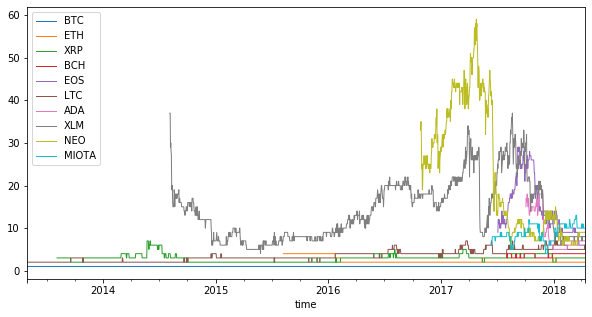

In [15]:
plotting(df_container, 'rank')